<a href="https://colab.research.google.com/github/PatrikEdelenji/DD2358-project/blob/gpu-optim/gpu-optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

         8957779 function calls (8745308 primitive calls) in 15.313 seconds

   Ordered by: internal time
   List reduced from 1301 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       36    3.258    0.090    3.258    0.090 {method 'encode' of 'ImagingEncoder' objects}
      376    0.964    0.003    0.964    0.003 <ipython-input-9-35b2f8725fed>:13(W)
      126    0.537    0.004    0.537    0.004 <ipython-input-9-35b2f8725fed>:26(gradW)
      502    0.405    0.001    0.407    0.001 <ipython-input-9-35b2f8725fed>:42(getPairwiseSeparations)
    35370    0.313    0.000    1.855    0.000 artist.py:1188(_update_props)


         8971540 function calls (8759069 primitive calls) in 82.976 seconds

   Ordered by: internal time
   List reduced from 1301 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      376   28.441    0.076   28.441    0.076 <ipython-input-9-35b2f8725fed>:13(W)
      1

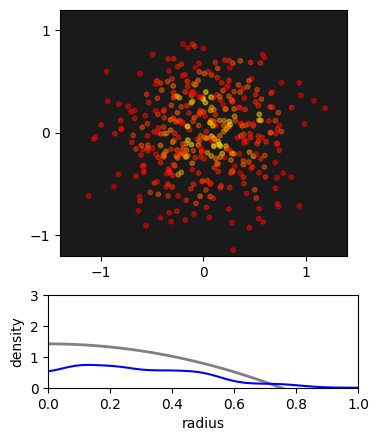

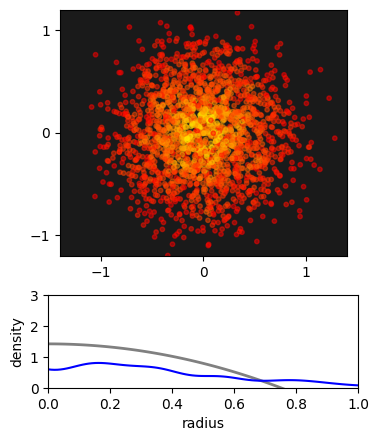

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import cProfile, pstats

"""
Create Your Own Smoothed-Particle-Hydrodynamics Simulation (With Python)
Philip Mocz (2020) Princeton University, @PMocz

Simulate the structure of a star with SPH
"""

def W(x, y, z, h):
    """
    Gaussian Smoothing kernel (3D)
    x     is a vector/matrix of x positions
    y     is a vector/matrix of y positions
    z     is a vector/matrix of z positions
    h     is the smoothing length
    w     is the evaluated smoothing function
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    w = (1.0 / (h * np.sqrt(np.pi)))**3 * np.exp(-r**2 / h**2)
    return w

def gradW(x, y, z, h):
    """
    Gradient of the Gaussian Smoothing kernel (3D)
    x     is a vector/matrix of x positions
    y     is a vector/matrix of y positions
    z     is a vector/matrix of z positions
    h     is the smoothing length
    wx, wy, wz     is the evaluated gradient
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    n = -2 * np.exp(-r**2 / h**2) / (h**5 * (np.pi)**(3/2))
    wx = n * x
    wy = n * y
    wz = n * z
    return wx, wy, wz

def getPairwiseSeparations(ri, rj):
    """
    Get pairwise separations between 2 sets of coordinates
    ri    is an M x 3 matrix of positions
    rj    is an N x 3 matrix of positions
    dx, dy, dz   are M x N matrices of separations
    """
    M = ri.shape[0]
    N = rj.shape[0]
    # positions ri = (x,y,z)
    rix = ri[:, 0].reshape((M, 1))
    riy = ri[:, 1].reshape((M, 1))
    riz = ri[:, 2].reshape((M, 1))
    # positions rj = (x,y,z)
    rjx = rj[:, 0].reshape((N, 1))
    rjy = rj[:, 1].reshape((N, 1))
    rjz = rj[:, 2].reshape((N, 1))
    dx = rix - rjx.T
    dy = riy - rjy.T
    dz = riz - rjz.T
    return dx, dy, dz

def getDensity(r, pos, m, h):
    """
    Get Density at sampling locations from SPH particle distribution
    r     is an M x 3 matrix of sampling locations
    pos   is an N x 3 matrix of SPH particle positions
    m     is the particle mass
    h     is the smoothing length
    rho   is an M x 1 vector of densities
    """
    M = r.shape[0]
    dx, dy, dz = getPairwiseSeparations(r, pos)
    rho = np.sum(m * W(dx, dy, dz, h), axis=1).reshape((M, 1))
    return rho

def getPressure(rho, k, n):
    """
    Equation of State
    rho   vector of densities
    k     equation of state constant
    n     polytropic index
    P     pressure
    """
    P = k * rho**(1+1/n)
    return P

def getAcc(pos, vel, m, h, k, n, lmbda, nu):
    """
    Calculate the acceleration on each SPH particle
    pos   is an N x 3 matrix of positions
    vel   is an N x 3 matrix of velocities
    m     is the particle mass
    h     is the smoothing length
    k     equation of state constant
    n     polytropic index
    lmbda external force constant
    nu    viscosity
    a     is an N x 3 matrix of accelerations
    """
    N = pos.shape[0]
    # Calculate densities at the position of the particles
    rho = getDensity(pos, pos, m, h)
    # Get the pressures
    P = getPressure(rho, k, n)
    # Get pairwise distances and gradients
    dx, dy, dz = getPairwiseSeparations(pos, pos)
    dWx, dWy, dWz = gradW(dx, dy, dz, h)
    ax = -np.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWx, axis=1).reshape((N,1))
    ay = -np.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWy, axis=1).reshape((N,1))
    az = -np.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWz, axis=1).reshape((N,1))
    a = np.hstack((ax, ay, az))
    # Add external potential force and viscosity
    a -= lmbda * pos
    a -= nu * vel
    return a

def main(N = 400):
    """ SPH simulation """
    # Simulation parameters
    #N         = 400    # Number of particles
    t         = 0       # current time of the simulation
    tEnd      = 5      # time at which simulation ends
    dt        = 0.04    # timestep
    M         = 1       # star mass
    R         = 0.75    # star radius
    h         = 0.1     # smoothing length
    k         = 0.1     # equation of state constant
    n         = 1       # polytropic index
    nu        = 0.001   # damping
    plotRealTime = True  # switch on for plotting as the simulation goes along

    # Generate Initial Conditions
    np.random.seed(42)
    lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2
    m     = M/N                    # single particle mass
    pos   = np.random.randn(N,3)   # randomly selected positions
    vel   = np.zeros(pos.shape)    # initial velocities (zero)

    # calculate initial gravitational accelerations
    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)

    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # prep figure
    fig = plt.figure(figsize=(4,5), dpi=100)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax1 = plt.subplot(grid[0:2,0])
    ax2 = plt.subplot(grid[2,0])
    rr = np.zeros((100,3))
    rlin = np.linspace(0,1,100)
    rr[:,0] = rlin
    rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)

    # Simulation Main Loop
    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2

        # drift
        pos += vel * dt

        # update accelerations
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)

        # (1/2) kick
        vel += acc * dt/2

        # update time
        t += dt

        # get density for plotting
        rho = getDensity(pos, pos, m, h)

        # plot in real time
        if plotRealTime or (i == Nt-1):
            plt.sca(ax1)
            plt.cla()
            cval = np.minimum((rho-3)/3,1).flatten()
            plt.scatter(pos[:,0], pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
            ax1.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
            ax1.set_aspect('equal', 'box')
            ax1.set_xticks([-1,0,1])
            ax1.set_yticks([-1,0,1])
            ax1.set_facecolor('black')
            ax1.set_facecolor((.1,.1,.1))

            plt.sca(ax2)
            plt.cla()
            ax2.set(xlim=(0, 1), ylim=(0, 3))
            ax2.set_aspect(0.1)
            plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
            rho_radial = getDensity(rr, pos, m, h)
            plt.plot(rlin, rho_radial, color='blue')
            # plt.pause(0.001)

    # add labels/legend
    plt.sca(ax2)
    plt.xlabel('radius')
    plt.ylabel('density')

    # Save figure
    plt.savefig('sph.png',dpi=1920)
    #plt.show()

    return 0

if __name__== "__main__":
    # Run the main function under cProfile and print the top 20 functions by cumulative time.
    profiler = cProfile.Profile()
    profiler.enable()
    main()
    profiler.disable()
    stats = pstats.Stats(profiler).strip_dirs().sort_stats('time')
    stats.print_stats(5)

    profiler = cProfile.Profile()
    profiler.enable()
    main(2000)
    profiler.disable()
    stats = pstats.Stats(profiler).strip_dirs().sort_stats('time')
    stats.print_stats(5)


         8972375 function calls (8760037 primitive calls) in 15.133 seconds

   Ordered by: internal time
   List reduced from 1331 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       36    4.163    0.116    4.163    0.116 {method 'encode' of 'ImagingEncoder' objects}
   191159    0.390    0.000    0.434    0.000 __init__.py:100(check_in_list)
      750    0.369    0.000    0.372    0.000 {method 'get' of 'cupy._core.core._ndarray_base' objects}
    35370    0.344    0.000    1.717    0.000 artist.py:1188(_update_props)
96867/96117    0.239    0.000    0.615    0.000 cbook.py:348(process)


         8986002 function calls (8773664 primitive calls) in 20.178 seconds

   Ordered by: internal time
   List reduced from 1331 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      750    6.264    0.008    6.268    0.008 {method 'get' of 'cupy._core.core._ndarray_base' objects}
       96

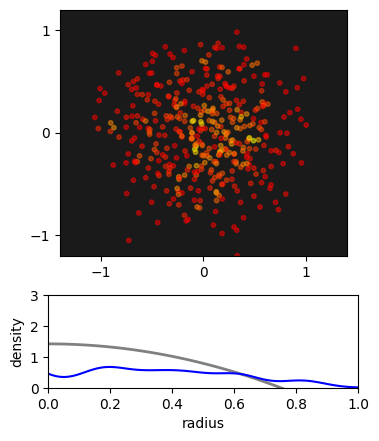

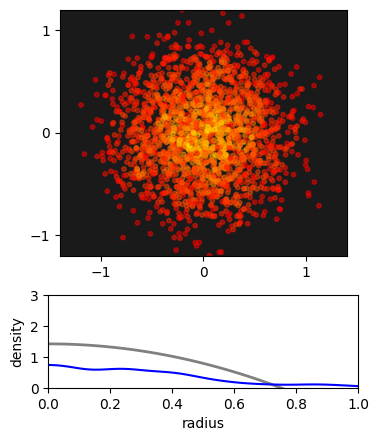

In [ ]:
import cupy as cp
import matplotlib.pyplot as plt
from scipy.special import gamma
import cProfile, pstats

"""
Create Your Own Smoothed-Particle-Hydrodynamics Simulation (With Python)
Philip Mocz (2020) Princeton University, @PMocz

Simulate the structure of a star with SPH using CuPy on GPU.
"""

def W(x, y, z, h):
    """
    Gaussian Smoothing kernel (3D) using CuPy.
    x, y, z : GPU arrays of positions
    h       : smoothing length
    Returns: evaluated smoothing function (GPU array)
    """
    r = cp.sqrt(x**2 + y**2 + z**2)
    w = (1.0/(h * cp.sqrt(cp.pi)))**3 * cp.exp(-r**2/(h**2))
    return w

def gradW(x, y, z, h):
    """
    Gradient of the Gaussian Smoothing kernel (3D) using CuPy.
    Returns: wx, wy, wz (GPU arrays)
    """
    r = cp.sqrt(x**2 + y**2 + z**2)
    n = -2 * cp.exp(-r**2/(h**2)) / (h**5 * (cp.pi)**(3/2))
    wx = n * x
    wy = n * y
    wz = n * z
    return wx, wy, wz

def getPairwiseSeparations(ri, rj):
    """
    Get pairwise separations between two sets of coordinates (GPU arrays).
    Returns: dx, dy, dz (GPU arrays)
    """
    M = ri.shape[0]
    N = rj.shape[0]
    # Reshape for broadcasting
    rix = ri[:, 0].reshape((M, 1))
    riy = ri[:, 1].reshape((M, 1))
    riz = ri[:, 2].reshape((M, 1))
    rjx = rj[:, 0].reshape((N, 1))
    rjy = rj[:, 1].reshape((N, 1))
    rjz = rj[:, 2].reshape((N, 1))
    dx = rix - rjx.T
    dy = riy - rjy.T
    dz = riz - rjz.T
    return dx, dy, dz

def getDensity(r, pos, m, h):
    """
    Get Density at sampling locations from SPH particle distribution.
    All arrays are GPU arrays.
    """
    M = r.shape[0]
    dx, dy, dz = getPairwiseSeparations(r, pos)
    rho = cp.sum(m * W(dx, dy, dz, h), axis=1).reshape((M, 1))
    return rho

def getPressure(rho, k, n):
    """
    Equation of State: P = k * rho^(1+1/n)
    """
    P = k * rho**(1+1/n)
    return P

def getAcc(pos, vel, m, h, k, n, lmbda, nu):
    """
    Calculate the acceleration on each SPH particle.
    All arrays are GPU arrays.
    """
    N = pos.shape[0]
    rho = getDensity(pos, pos, m, h)
    P = getPressure(rho, k, n)
    dx, dy, dz = getPairwiseSeparations(pos, pos)
    dWx, dWy, dWz = gradW(dx, dy, dz, h)
    ax = -cp.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWx, axis=1).reshape((N,1))
    ay = -cp.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWy, axis=1).reshape((N,1))
    az = -cp.sum(m * (P/rho**2 + P.T/(rho.T**2)) * dWz, axis=1).reshape((N,1))
    a = cp.hstack((ax, ay, az))
    a -= lmbda * pos
    a -= nu * vel
    return a

def main(N=400):
    """
    SPH simulation using CuPy.
    """
    t = 0
    tEnd = 5
    dt = 0.04
    M = 1
    R = 0.75
    h = 0.1
    k = 0.1
    n = 1
    nu = 0.001
    plotRealTime = True

    cp.random.seed(42)
    # Compute lmbda on GPU. Note: gamma is computed on CPU; for one-time computation it's acceptable.
    lmbda = 2*k*(1+n)*cp.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2
    m = M/N
    pos = cp.random.randn(N, 3)
    vel = cp.zeros((N, 3), dtype=cp.double)

    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
    Nt = int(cp.ceil(tEnd/dt))

    # Prepare plotting: create CPU arrays for rlin, etc.
    fig = plt.figure(figsize=(4,5), dpi=100)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax1 = plt.subplot(grid[0:2,0])
    ax2 = plt.subplot(grid[2,0])
    rr = cp.zeros((100,3), dtype=cp.double)
    rlin = cp.linspace(0, 1, 100)
    rr[:,0] = rlin
    rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)

    for i in range(Nt):
        vel += acc * dt/2
        pos += vel * dt
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
        vel += acc * dt/2
        t += dt
        rho = getDensity(pos, pos, m, h)
        if plotRealTime or (i == Nt - 1):
            # Convert GPU arrays to CPU arrays for plotting.
            pos_cpu = cp.asnumpy(pos)
            rho_cpu = cp.asnumpy(rho)
            rlin_cpu = cp.asnumpy(rlin)
            rho_analytic_cpu = cp.asnumpy(rho_analytic)
            # Use cp.minimum on the GPU; then convert the result.
            cval = cp.minimum((rho - 3)/3, cp.array(1, dtype=rho.dtype)).flatten().get()

            plt.sca(ax1)
            plt.cla()
            plt.scatter(pos_cpu[:,0], pos_cpu[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
            ax1.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
            ax1.set_aspect('equal', 'box')
            ax1.set_xticks([-1,0,1])
            ax1.set_yticks([-1,0,1])
            ax1.set_facecolor((0.1,0.1,0.1))

            plt.sca(ax2)
            plt.cla()
            ax2.set(xlim=(0,1), ylim=(0,3))
            ax2.set_aspect(0.1)
            plt.plot(rlin_cpu, rho_analytic_cpu, color='gray', linewidth=2)
            # Compute radial density and convert to CPU
            rho_radial = getDensity(rr, pos, m, h)
            plt.plot(rlin_cpu, cp.asnumpy(rho_radial), color='blue')
            # plt.pause(0.001)

    plt.sca(ax2)
    plt.xlabel('radius')
    plt.ylabel('density')
    plt.savefig('sph.png', dpi=1920)
    # plt.show()  # Uncomment to display the figure interactively.
    return 0

if __name__ == "__main__":
    # Optionally, run profiling on the simulation.
    profiler = cProfile.Profile()
    profiler.enable()
    main(400)
    profiler.disable()
    stats = pstats.Stats(profiler).strip_dirs().sort_stats('time')
    stats.print_stats(5)

    profiler = cProfile.Profile()
    profiler.enable()
    main(2000)
    profiler.disable()
    stats = pstats.Stats(profiler).strip_dirs().sort_stats('time')
    stats.print_stats(5)


         10194793 function calls (9946302 primitive calls) in 20.159 seconds

   Ordered by: internal time
   List reduced from 1489 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       67    3.999    0.060    3.999    0.060 {method 'encode' of 'ImagingEncoder' objects}
      750    3.355    0.004    3.355    0.004 {method '_numpy_internal' of 'tensorflow.python.framework.ops.EagerTensor' objects}
    20143    1.119    0.000    1.119    0.000 {built-in method tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute}
        2    0.890    0.445    0.894    0.447 {built-in method matplotlib.backends._backend_agg.draw_path_collection}
    11450    0.371    0.000    0.391    0.000 constant_op.py:75(convert_to_eager_tensor)


         10178912 function calls (9930421 primitive calls) in 16.993 seconds

   Ordered by: internal time
   List reduced from 1489 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:l

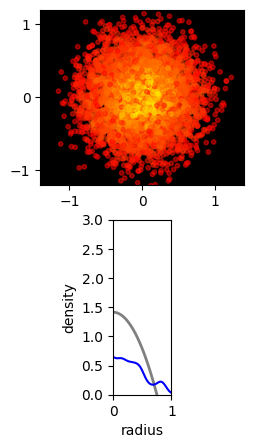

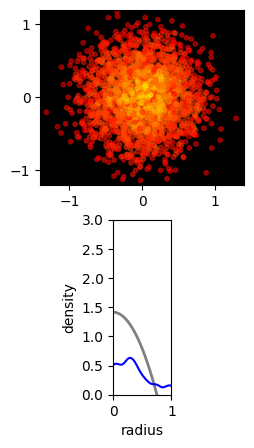

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import cProfile, pstats

"""
Create Your Own Smoothed-Particle-Hydrodynamics Simulation (With Python)
Philip Mocz (2020) Princeton University, @PMocz

This version uses TensorFlow for GPU acceleration.
"""

def W(x, y, z, h):
    """
    Gaussian Smoothing kernel (3D) using TensorFlow.
    x, y, z : TensorFlow tensors (GPU arrays) representing positions.
    h       : smoothing length (scalar)
    Returns : Tensor of kernel values.
    """
    r = tf.math.sqrt(x**2 + y**2 + z**2)
    pi_const = tf.constant(np.pi, dtype=x.dtype)
    factor = (1.0 / (h * tf.math.sqrt(pi_const)))**3
    w = factor * tf.math.exp(-r**2 / (h**2))
    return w

def gradW(x, y, z, h):
    """
    Gradient of the Gaussian Smoothing kernel (3D) using TensorFlow.
    Returns 3 tensors: wx, wy, wz.
    """
    r = tf.math.sqrt(x**2 + y**2 + z**2)
    pi_const = tf.constant(np.pi, dtype=x.dtype)
    n = -2 * tf.math.exp(-r**2 / (h**2)) / (h**5 * tf.math.pow(pi_const, 1.5))
    wx = n * x
    wy = n * y
    wz = n * z
    return wx, wy, wz

def getPairwiseSeparations(ri, rj):
    """
    Get pairwise separations between two sets of coordinates.
    ri: Tensor of shape [M, 3]
    rj: Tensor of shape [N, 3]
    Returns:
         dx, dy, dz : each a tensor of shape [M, N].
    """
    rix = tf.expand_dims(ri[:, 0], axis=1)  # shape [M, 1]
    riy = tf.expand_dims(ri[:, 1], axis=1)
    riz = tf.expand_dims(ri[:, 2], axis=1)
    rjx = tf.expand_dims(rj[:, 0], axis=0)   # shape [1, N]
    rjy = tf.expand_dims(rj[:, 1], axis=0)
    rjz = tf.expand_dims(rj[:, 2], axis=0)
    dx = rix - rjx
    dy = riy - rjy
    dz = riz - rjz
    return dx, dy, dz

def getDensity(r, pos, m, h):
    """
    Get density at sampling locations from the SPH particle distribution.
    r: Tensor of shape [M, 3] (sampling locations)
    pos: Tensor of shape [N, 3] (particle positions)
    m: particle mass (scalar, as a tf.constant)
    h: smoothing length (scalar)
    Returns:
         rho: Tensor of shape [M, 1]
    """
    dx, dy, dz = getPairwiseSeparations(r, pos)
    w = W(dx, dy, dz, h)
    rho = tf.reduce_sum(m * w, axis=1, keepdims=True)
    return rho

def getPressure(rho, k, n):
    """
    Equation of State: P = k * rho^(1 + 1/n)
    """
    P = k * tf.pow(rho, 1.0 + 1.0/n)
    return P

def getAcc(pos, vel, m, h, k, n, lmbda, nu):
    """
    Calculate the acceleration on each SPH particle.
    pos, vel: Tensors of shape [N, 3]
    m: particle mass (scalar tf.constant)
    h: smoothing length (scalar)
    k: equation-of-state constant (scalar)
    n: polytropic index (integer)
    lmbda: external force constant (scalar tf.constant)
    nu: viscosity (scalar)
    Returns:
         a: Tensor of shape [N, 3]
    """
    rho = getDensity(pos, pos, m, h)       # [N, 1]
    P = getPressure(rho, k, n)             # [N, 1]
    dx, dy, dz = getPairwiseSeparations(pos, pos)  # each [N, N]
    dWx, dWy, dWz = gradW(dx, dy, dz, h)           # each [N, N]
    term1 = P / tf.pow(rho, 2)             # [N, 1]
    term_total = term1 + tf.transpose(term1)  # [N, N]
    ax = -tf.reduce_sum(m * term_total * dWx, axis=1, keepdims=True)
    ay = -tf.reduce_sum(m * term_total * dWy, axis=1, keepdims=True)
    az = -tf.reduce_sum(m * term_total * dWz, axis=1, keepdims=True)
    a = tf.concat([ax, ay, az], axis=1)
    a = a - lmbda * pos - nu * vel
    return a

def main(N=400):
    """
    SPH simulation using TensorFlow.
    """
    t = 0.0
    tEnd = 5.0
    dt = 0.04
    M = 1.0
    R = 0.75
    h = 0.1
    k = 0.1
    n = 1
    nu = 0.001
    plotRealTime = True

    # Use TensorFlow's random generator.
    tf.random.set_seed(42)

    # Compute lmbda using scipy.special.gamma (CPU) and convert to tf.float32.
    lmbda_val = 2*k*(1+n)* (np.pi**(-3/(2*n))) * ((M*gamma(5/2+n))/(R**3)/gamma(1+n))**(1/n) / R**2
    lmbda = tf.constant(lmbda_val, dtype=tf.float32)
    m_val = M / N
    m_const = tf.constant(m_val, dtype=tf.float32)

    pos = tf.random.normal([N, 3], dtype=tf.float32)
    vel = tf.zeros([N, 3], dtype=tf.float32)

    acc = getAcc(pos, vel, m_const, h, k, n, lmbda, nu)
    Nt = int(np.ceil(tEnd/dt))

    # Prepare plotting data (these will be converted to CPU arrays for Matplotlib).
    fig = plt.figure(figsize=(4,5), dpi=100)
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    # Create a tensor rr of shape [100, 3] with rr[:,0] = linspace(0,1) and zeros elsewhere.
    rlin = tf.linspace(0.0, 1.0, 100)
    rr = tf.concat([tf.reshape(rlin, [-1, 1]), tf.zeros([100, 2], dtype=tf.float32)], axis=1)
    rho_analytic = lmbda/(4*k) * (R**2 - tf.pow(rlin, 2))  # shape [100]

    for i in range(Nt):
        vel = vel + acc * (dt/2)
        pos = pos + vel * dt
        acc = getAcc(pos, vel, m_const, h, k, n, lmbda, nu)
        vel = vel + acc * (dt/2)
        t += dt
        rho = getDensity(pos, pos, m_const, h)
        if plotRealTime or (i == Nt - 1):
            # Convert TensorFlow tensors (on GPU) to NumPy arrays.
            pos_cpu = pos.numpy()
            rho_cpu = rho.numpy()
            rlin_cpu = rlin.numpy()
            rho_analytic_cpu = rho_analytic.numpy()
            # Use tf.minimum on GPU then convert to NumPy.
            cval = tf.minimum((rho - 3)/3, 1.0)
            cval_cpu = cval.numpy().flatten()

            ax1.cla()
            ax1.scatter(pos_cpu[:,0], pos_cpu[:,1], c=cval_cpu, cmap='autumn', s=10, alpha=0.5)
            ax1.set_xlim(-1.4, 1.4)
            ax1.set_ylim(-1.2, 1.2)
            ax1.set_aspect('equal', 'box')
            ax1.set_xticks([-1, 0, 1])
            ax1.set_yticks([-1, 0, 1])
            ax1.set_facecolor('black')

            ax2.cla()
            ax2.set_xlim(0,1)
            ax2.set_ylim(0,3)
            ax2.set_aspect('equal')
            ax2.plot(rlin_cpu, rho_analytic_cpu, color='gray', linewidth=2)
            rho_radial = getDensity(rr, pos, m_const, h)
            ax2.plot(rlin_cpu, rho_radial.numpy().flatten(), color='blue')
            # plt.pause(0.001)

    ax2.set_xlabel('radius')
    ax2.set_ylabel('density')
    plt.savefig('sph_tf.png', dpi=1920)
    # plt.show()  # Uncomment to display the figure interactively.
    return 0

if __name__ == "__main__":
    # Optionally, profile the code with cProfile.
    profiler = cProfile.Profile()
    profiler.enable()
    main(4000)
    profiler.disable()
    stats = pstats.Stats(profiler).strip_dirs().sort_stats('time')
    stats.print_stats(5)

    profiler = cProfile.Profile()
    profiler.enable()
    main(2000)
    profiler.disable()
    stats = pstats.Stats(profiler).strip_dirs().sort_stats('time')
    stats.print_stats(5)
